## Kaggle - 
https://www.kaggle.com/c/restaurant-revenue-prediction

In [1]:
import numpy as np # linear algebra
import datetime as dt
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pandas.api.types import *

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns 

import warnings
warnings.filterwarnings("ignore")

import os
print(os.listdir("/Users/tejaswinalwad/Machine_Learning/Kaggle_Projects/Restaurant Revenue Prediction"))

['Res_Rev_submission.csv', 'sampleSubmission.csv', 'Restaurant_Revenue_with_featexp .ipynb', 'test.csv', 'untitled.txt', 'RR_with_Corsera_approach.ipynb', 'train.csv', '.ipynb_checkpoints', 'Restaurant_Revenue_Prediction.ipynb', 'test.csv.zip', 'train.csv.zip', 'Res_Rev_submission_gbc.csv']


In [3]:
train_raw  = pd.read_csv("/Users/tejaswinalwad/Machine_Learning/Kaggle_Projects/Restaurant Revenue Prediction/train.csv")
test_data = pd.read_csv("/Users/tejaswinalwad/Machine_Learning/Kaggle_Projects/Restaurant Revenue Prediction/test.csv")

**change dtype of 'Open Date' from object to datetime64**

In [4]:
from datetime import datetime
import datetime as dt
train_raw['Open Date'] = train_raw['Open Date'].apply(lambda x: dt.datetime.strptime(x,'%m/%d/%Y'))
test_data['Open Date'] = test_data['Open Date'].apply(lambda x: dt.datetime.strptime(x,'%m/%d/%Y'))

**Helper Functions**

In [5]:
import math
train_raw.revenue = np.log(train_raw.revenue)

def rmse(x, y): 
    return math.sqrt(((x-y)**2).mean())

In [6]:
def print_score(m):
    res  = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
           m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [7]:
from sklearn.metrics import mean_squared_log_error, mean_squared_error
def sk_print_score(m):
    res  = [mean_squared_log_error(m.predict(X_train), y_train), mean_squared_log_error(m.predict(X_valid), y_valid),
           mean_squared_error(m.predict(X_train), y_train), mean_squared_error(m.predict(X_valid), y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [8]:
import re
def add_datepart(df, fldname):
    fld = df[fldname]
    print(fld.dt)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    for n in ('Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear', 
             'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start',):
        df[targ_pre+n] = getattr(fld.dt,n.lower())
    df[targ_pre+'Elapsed'] = (fld - fld.min()).dt.days
    df.drop(fldname, axis=1, inplace=True)

In [9]:
def get_sample(df,n):
    idxs = sorted(np.random.permutation(len(df))[:n])
    return df.iloc[idxs].copy()

In [10]:
def apply_cats(df,trn):
    for n,c in df.items():
        if trn[n].dtype.name == 'category':
            df[n] = pd.Categorical(c,categories=trn[n].cat.categories, ordered=True)
            pd.Categorical()

In [11]:
def train_cats(df):
    for n,c in df.items():
        if is_string_dtype(c):
            df[n] = c.astype('category').cat.as_ordered()

In [12]:
def fix_missing(df, col, name, na_dict):
    if is_numeric_dtype(col):
        if pd.isnull(col).sum() or (name in na_dict):
            df[name+'_na'] = pd.isnull(col)
            filler = na_dict[name] if name in na_dict else col.median()
            df[name] = col.fillna(filler)
            na_dict[name] = filler
    return na_dict

In [13]:
def numericalize(df, col, name, max_n_cat=None):
    if not is_numeric_dtype(col) and (max_n_cat is None or col.nunique()>max_n_cat):
        df[name] = col.cat.codes+1
#     return (df)

In [14]:
def scale_vars(df, mapper):
    warnings.filterwarnings('ignore', category=sklearn.exceptions.DataConversionWarning)
    if mapper is None:
        map_f = [([n],StandardScaler()) for n in df.columns if is_numeric_dtype(df[n])]
        mapper = DataFrameMapper(map_f).fit(df)
    df[mapper.transformed_names_] = mapper.transform(df)
    return mapper

In [15]:
def proc_df(df, y_fld=None, skip_flds=None, ignore_flds=None, do_scale=False, na_dict=None,
            preproc_fn=None, max_n_cat=None, subset=None, mapper=None):
    if not ignore_flds: ignore_flds=[]
    if not skip_flds: skip_flds=[]
    if subset: df = get_sample(df,subset)
    ignored_flds = df.loc[:, ignore_flds]
    df.drop(ignore_flds, axis=1, inplace=True)
    df = df.copy()
    if preproc_fn: preproc_fn(df)
    if y_fld is None: y = None
    else:
        if not is_numeric_dtype(df[y_fld]): df[y_fld] = df[y_fld].cat.codes
        y = df[y_fld].values
        skip_flds += [y_fld]
    df.drop(skip_flds, axis=1, inplace=True)

    if na_dict is None: na_dict = {}
    for n,c in df.items(): na_dict = fix_missing(df, c, n, na_dict)
    if do_scale: mapper = scale_vars(df, mapper)
    for n,c in df.items(): numericalize(df, c, n, max_n_cat)
    df = pd.get_dummies(df, dummy_na=True)
    df = pd.concat([ignored_flds, df], axis=1)
    res = [df, y, na_dict]
    if do_scale: res = res + [mapper]
    return res

In [16]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

In [17]:
train_raw.columns

Index(['Id', 'Open Date', 'City', 'City Group', 'Type', 'P1', 'P2', 'P3', 'P4',
       'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11', 'P12', 'P13', 'P14', 'P15',
       'P16', 'P17', 'P18', 'P19', 'P20', 'P21', 'P22', 'P23', 'P24', 'P25',
       'P26', 'P27', 'P28', 'P29', 'P30', 'P31', 'P32', 'P33', 'P34', 'P35',
       'P36', 'P37', 'revenue'],
      dtype='object')

In [18]:
train_raw.head()

,Id,Open Date,City,City Group,Type,P1,P2,P3,P4,P5,...,P29,P30,P31,P32,P33,P34,P35,P36,P37,revenue
0,0,1999-07-17,İstanbul,Big Cities,IL,4,5.0,4.0,4.0,2,...,3.0,5,3,4,5,5,4,3,4,15.547830
1,1,2008-02-14,Ankara,Big Cities,FC,4,5.0,4.0,4.0,1,...,3.0,0,0,0,0,0,0,0,0,15.750379
2,2,2013-03-09,Diyarbakır,Other,IL,2,4.0,2.0,5.0,2,...,3.0,0,0,0,0,0,0,0,0,14.535971
3,3,2012-02-02,Tokat,Other,IL,6,4.5,6.0,6.0,4,...,7.5,25,12,10,6,18,12,12,6,14.799651
4,4,2009-05-09,Gaziantep,Other,IL,3,4.0,3.0,4.0,2,...,3.0,5,1,3,2,3,4,3,3,15.278005


In [19]:
test_data.head()

,Id,Open Date,City,City Group,Type,P1,P2,P3,P4,P5,...,P28,P29,P30,P31,P32,P33,P34,P35,P36,P37
0,0,2011-01-22,Niğde,Other,FC,1,4.0,4.0,4.0,1,...,2.0,3.0,0,0,0,0,0,0,0,0
1,1,2011-03-18,Konya,Other,IL,3,4.0,4.0,4.0,2,...,1.0,3.0,0,0,0,0,0,0,0,0
2,2,2013-10-30,Ankara,Big Cities,FC,3,4.0,4.0,4.0,2,...,2.0,3.0,0,0,0,0,0,0,0,0
3,3,2013-05-06,Kocaeli,Other,IL,2,4.0,4.0,4.0,2,...,2.0,3.0,0,4,0,0,0,0,0,0
4,4,2013-07-31,Afyonkarahisar,Other,FC,2,4.0,4.0,4.0,1,...,5.0,3.0,0,0,0,0,0,0,0,0


In [20]:
# train_raw.info()

In [21]:
train_raw.isnull().sum().any()

False

In [22]:
train_raw.shape

(137, 43)

In [23]:
add_datepart(train_raw, 'Open Date')
add_datepart(test_data, 'Open Date')

In [24]:
train_raw['Type'].value_counts()

FC    76
IL    60
DT     1
Name: Type, dtype: int64

In [25]:
train_raw['City Group'].value_counts()

Big Cities    78
Other         59
Name: City Group, dtype: int64

In [26]:
test_data['Type'].value_counts()

FC    57019
IL    40447
DT     2244
MB      290
Name: Type, dtype: int64

In [27]:
train_cats(train_raw)

In [28]:
train_raw.Type.cat.categories

Index(['DT', 'FC', 'IL'], dtype='object')

In [29]:
# train_data.Type.cat.set_categories(['DT', 'FC', 'IL'], ordered=True, inplace=True)

In [30]:
train_cats(test_data) 
# apply_cats(test_data, train_raw)

In [31]:
# for n,c in train_data.items(): numericalize(train_data, c, n)
# X_test, y_test, nas = proc_df(test_data, 'revenue', na_dict=None)

In [34]:
for n,c in test_data.items(): numericalize(test_data, c, n)

In [35]:
test_data.head()

,Id,City,City Group,Type,P1,P2,P3,P4,P5,P6,...,Open Month,Open Week,Open Day,Open Dayofweek,Open Dayofyear,Open Is_month_end,Open Is_month_start,Open Is_quarter_end,Open Is_quarter_start,Open Elapsed
0,0,39,2,2,1,4.0,4.0,4.0,1,2,...,1,3,22,5,22,False,False,False,False,5738
1,1,28,2,3,3,4.0,4.0,4.0,2,2,...,3,11,18,4,77,False,False,False,False,5793
2,2,4,1,2,3,4.0,4.0,4.0,2,2,...,10,44,30,2,303,False,False,False,False,6750
3,3,27,2,3,2,4.0,4.0,4.0,2,3,...,5,19,6,0,126,False,False,False,False,6573
4,4,2,2,2,2,4.0,4.0,4.0,1,2,...,7,31,31,2,212,True,False,False,False,6659


In [36]:
X, y, nas = proc_df(train_raw, 'revenue', na_dict=None)

In [37]:
# from sklearn.model_selection import train_test_split

# X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=1)
# X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

n_valid = 30  # same as Kaggle's test set size
n_trn = len(X)-n_valid
# raw_train, raw_valid = split_vals(X, n_trn)
X_train, X_valid = split_vals(X, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape

((107, 51), (107,), (30, 51))

## First Random Forest

In [38]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, 
                        max_features=0.5, n_jobs=-1, oob_score=True )
rf.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=0.5, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=3, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [39]:
sk_print_score(rf)

[0.00021233869156113134, 0.0007239638657015241, 0.056744506982224115, 0.18984058502490173, 0.23911221624436096]


In [40]:
print_score(rf)

[0.23821105554156038, 0.4357069944640569, 0.7717109258757292, -0.17903162973298592, 0.23911221624436096]


**Feature Engineering**

In [41]:
%prun preds = np.stack([t.predict(X_valid) for t in rf.estimators_])
np.mean(preds[:,0]), np.std(preds[:,0])

(15.188262929226337, 0.3269877115734559)

In [42]:
%time preds = np.stack([t.predict(X_valid) for t in rf.estimators_])
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 21.6 ms, sys: 2.5 ms, total: 24.1 ms
Wall time: 21.7 ms


(15.188262929226337, 0.3269877115734559)

In [43]:
A = X_valid.copy()
A['pred_std'] = np.std(preds, axis=0)
A['pred'] = np.mean(preds, axis=0)

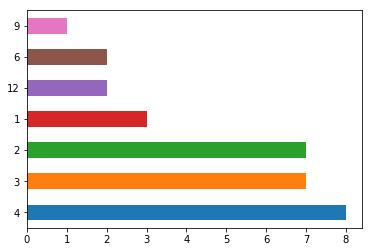

In [44]:
A.P1.value_counts().plot.barh()

In [45]:
FE = pd.DataFrame({'cols':X.columns, 'imp':rf.feature_importances_}
                       ).sort_values('imp', ascending=False)


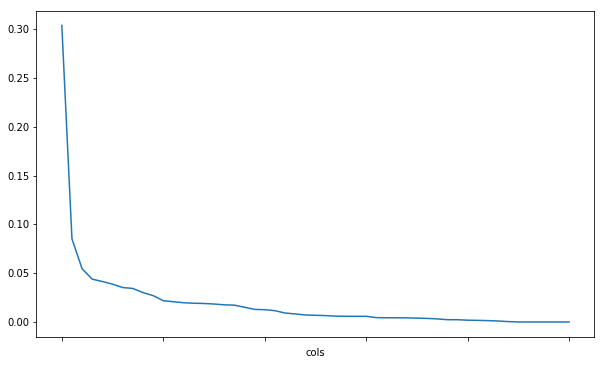

In [46]:
# to_keep = FE['imp']>0.01
FE.plot('cols', 'imp', figsize=(10,6), legend=False);

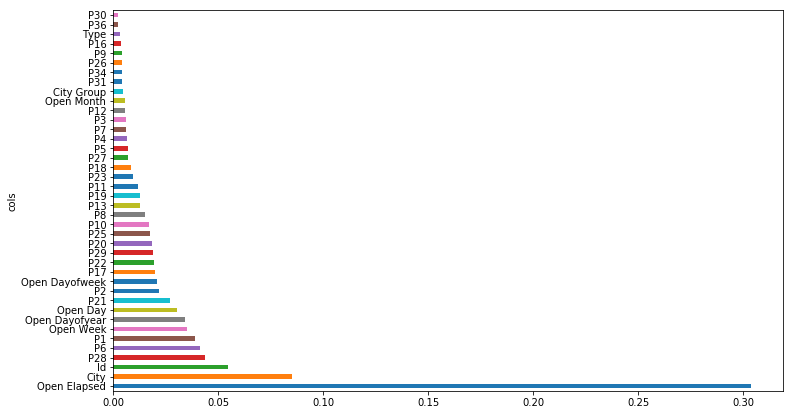

In [47]:
def plot_FE(FE): 
  return FE.plot('cols','imp','barh', figsize=(12,7), legend=False)

plot_FE(FE[:40]);

In [48]:
FE.imp.sort_values

<bound method Series.sort_values of 50    0.303679
1     0.085139
0     0.054459
31    0.043834
9     0.041442
4     0.038735
42    0.035262
45    0.034328
43    0.030107
24    0.026997
5     0.021790
44    0.020743
20    0.019703
25    0.019203
32    0.018940
23    0.018402
28    0.017573
13    0.017221
11    0.015135
16    0.012883
22    0.012555
14    0.011589
26    0.009174
21    0.008250
30    0.007167
8     0.006849
7     0.006530
10    0.005945
6     0.005852
15    0.005796
41    0.005796
2     0.004458
34    0.004307
37    0.004273
29    0.004235
12    0.003931
19    0.003659
3     0.003158
39    0.002344
33    0.002324
27    0.001814
40    0.001642
35    0.001385
17    0.001001
36    0.000391
38    0.000000
18    0.000000
46    0.000000
47    0.000000
48    0.000000
49    0.000000
Name: imp, dtype: float64>

In [49]:
to_keep = FE[FE.imp>0.01].cols
len(to_keep)

22

In [50]:
df_keep = X[to_keep].copy()

# n_valid = 30  # same as Kaggle's test set size
# n_trn = len(X)-n_valid
# raw_train, raw_valid = split_vals(df_raw, n_trn)
X_train, X_valid = split_vals(df_keep, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape
# X_train, X_valid, y_train, y_valid = train_test_split(df_keep, y, test_size=0.3, random_state=1)

((107, 22), (107,), (30, 22))

In [51]:
rf1 = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, 
                        max_features=0.5, n_jobs=-1, oob_score=True )
rf1.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=0.5, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=3, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [52]:
sk_print_score(rf1)

[0.00023281130880426856, 0.0007879064926764814, 0.06192856361094147, 0.20666876948765694, 0.28811909320516693]


In [53]:
print_score(rf1)

[0.24885450289464608, 0.4546083693550493, 0.7508549249883067, -0.2835454340386738, 0.28811909320516693]


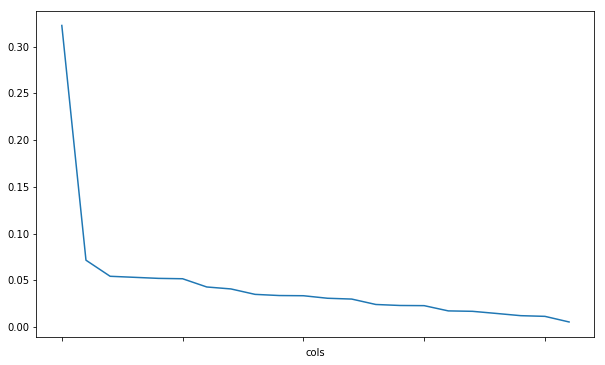

In [54]:
FE1 = pd.DataFrame({'cols':df_keep.columns, 'imp':rf1.feature_importances_}
                       ).sort_values('imp', ascending=False)
FE1.plot('cols', 'imp', figsize=(10,6), legend=False);

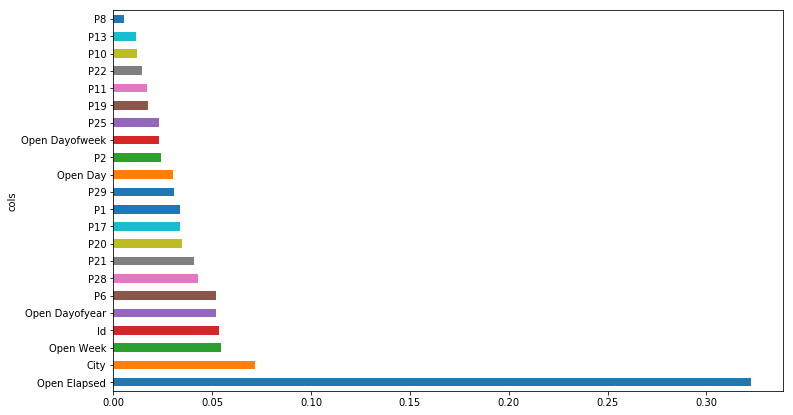

In [55]:
plot_FE(FE1)

**With One hot Encoding approach**

In [56]:
df_trn2, y_trn, nas = proc_df(train_raw, 'revenue', max_n_cat=7)

In [57]:
n_valid = 30  # same as Kaggle's test set size
n_trn = len(df_trn2)-n_valid
# raw_train, raw_valid = split_vals(df_raw, n_trn)
X_train, X_valid = split_vals(df_trn2, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)

X_train.shape, y_train.shape, X_valid.shape
# X_train, X_valid, y_train, y_valid = train_test_split(df_trn2, y_trn, test_size=0.3, random_state=1)

((107, 56), (107,), (30, 56))

In [58]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, 
       max_features=0.6, n_jobs=-1, oob_score=True) 
m.fit(X_train, y_train) 
print_score(m)

[0.23586042471597807, 0.4779891908368563, 0.7761941407662849, -0.41896781131539984, 0.2515230721945826]


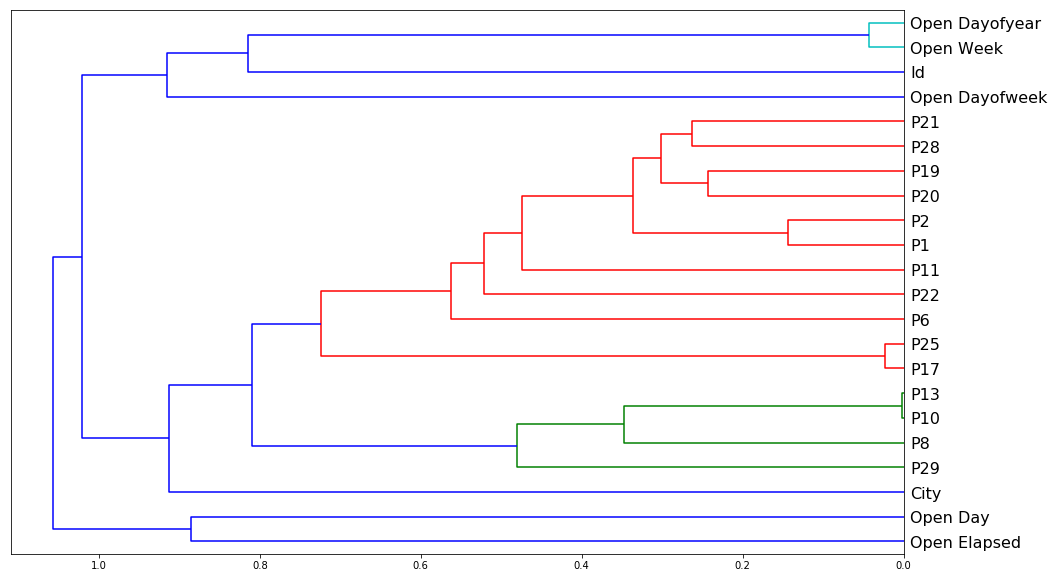

In [59]:
import scipy
from scipy.cluster import hierarchy as hc

corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, 
      orientation='left', leaf_font_size=16)
plt.show()

In [60]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=30, min_samples_leaf=5, 
           max_features=0.6, n_jobs=-1, oob_score=True)
    
    n_valid = 30  # same as Kaggle's test set size
    n_trn = 107
#     raw_train, raw_valid = split_vals(df_raw, n_trn)
    A_train, A_valid = split_vals(df_keep, n_trn)
    b_train, b_valid = split_vals(y_trn, n_trn)

    A_train.shape, b_train.shape, A_valid.shape
#     A_train, A_valid, b_train, b_valid = train_test_split(df_keep, y_trn, test_size=0.3, random_state=1)
    m.fit(A_train, y_train)
    return m.oob_score_

In [61]:
# X_train, X_valid, y_train, y_valid = train_test_split(df_trn2, y_trn, test_size=0.3, random_state=1)
# A_train.shape
df_keep.columns


Index(['Open Elapsed', 'City', 'Id', 'P28', 'P6', 'P1', 'Open Week',
       'Open Dayofyear', 'Open Day', 'P21', 'P2', 'Open Dayofweek', 'P17',
       'P22', 'P29', 'P20', 'P25', 'P10', 'P8', 'P13', 'P19', 'P11'],
      dtype='object')

In [64]:
for c in ('Open Elapsed', 'City', 'Id', 'Open Week', 'P6', 'P28', 'P20', 'P1',
       'Open Dayofyear', 'Open Day', 'P21', 'P23', 'P29', 'P11', 'P19',
       'Open Month', 'P2', 'P17', 'P22', 'Open Dayofweek', 'P4', 'P7'):
    print(c, get_oob(df_keep.drop(c, axis=1)))

Open Elapsed 0.21097379292829443
City 0.16730936030223043
Id 0.1944619163592768
Open Week 0.24662600221037778
P6 0.19453990968630108
P28 0.19510161153478578
P20 0.21312502285406043
P1 0.16781969619007653
Open Dayofyear 0.2088344906706614
Open Day 0.21740410679191147
P21 0.19763515021347156
P29 0.21955492364170304
P11 0.22297790067968382
P19 0.23198989117756363
P2 0.1785846787356168
P17 0.21348073303601767
P22 0.2195623809497388
Open Dayofweek 0.21696896071032434


KeyError: "['P4'] not found in axis"

In [65]:
to_drop = ['Id', 'P11', 'P19', 'P1', 'P6', 'Open Day', 'Open Month', 'Open Dayofweek', 'Open Elapsed']
df_keep.drop(to_drop, axis=1, inplace=True)

n_valid = 30  # same as Kaggle's test set size
n_trn = len(df_trn2)-n_valid
# raw_train, raw_valid = split_vals(df_keep, n_trn)
D_train, D_valid = split_vals(df_keep, n_trn)
e_train, e_valid = split_vals(y_trn, n_trn)

D_train.shape, e_train.shape, D_valid.shape
# D_train, D_valid, e_train, e_valid = train_test_split(df_keep, y_trn, test_size=0.3, random_state=1)
# np.save('keep_cols.npy', np.array(df_keep.columns))
# keep_cols = np.load('keep_cols.npy')
# df_keep = df_trn[keep_cols]

KeyError: "['Open Month'] not found in axis"

In [66]:
df_trn3, y_trn3, nas = proc_df(train_raw, 'revenue', max_n_cat=7)
df_trn3.drop(to_drop, axis=1, inplace=True)

n_valid = 30  # same as Kaggle's test set size
n_trn = len(df_trn3)-n_valid
# raw_train, raw_valid = split_vals(df_raw, n_trn)
X_train, X_valid = split_vals(df_trn3, n_trn)
y_train, y_valid = split_vals(y_trn3, n_trn)

X_train.shape, y_train.shape, X_valid.shape
# X_train, X_valid, y_train, y_valid = train_test_split(df_trn2, y_trn, test_size=0.3, random_state=1)


((107, 47), (107,), (30, 47))

In [67]:
m1 = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, 
       max_features=0.6, n_jobs=-1)
m1.fit(X_train, y_train)
print_score(m1)

[0.29458740730960914, 0.4037427187847173, 0.6508680002064758, -0.012385226287079831]


In [68]:
X_train.head()

,City,P2,P3,P4,P5,P7,P8,P9,P10,P12,...,Open Is_month_start,Open Is_quarter_end,Open Is_quarter_start,City Group_Big Cities,City Group_Other,City Group_nan,Type_DT,Type_FC,Type_IL,Type_nan
0,32,5.0,4.0,4.0,2,5,4,5,5,5,...,False,False,False,1,0,0,0,0,1,0
1,4,5.0,4.0,4.0,1,5,5,5,5,5,...,False,False,False,1,0,0,0,1,0,0
2,11,4.0,2.0,5.0,2,5,5,5,5,5,...,False,False,False,0,1,0,0,0,1,0
3,29,4.5,6.0,6.0,4,10,8,10,10,10,...,False,False,False,0,1,0,0,0,1,0
4,15,4.0,3.0,4.0,2,5,5,5,5,5,...,False,False,False,0,1,0,0,0,1,0


## Robust Regression using RANdom SAmple Consensus (RANSAC) Algorithm

In [69]:
# from sklearn.linear_model import RANSACRegressor
# ransac = RANSACRegressor(base_estimator=rf)
# ransac.fit(X_train,y_train)
# sk_print_score(ransac)

# AdaBoost / Adaptive Boosting

In [70]:
from sklearn.ensemble import AdaBoostRegressor
ada_clf = AdaBoostRegressor()
ada_clf.fit(X_train, y_train)
# print_score(ada_clf)
sk_print_score(ada_clf)

[0.00029373460599653884, 0.0008315989302357549, 0.07627462384650703, 0.2188178015960699]


In [71]:
print_score(ada_clf)

[0.2761786085968771, 0.4677796506861643, 0.69313922733436, -0.35899870513231913]


## AdaBoost with Random Forest

In [72]:
%%time
ada_clf_RF = AdaBoostRegressor(RandomForestRegressor(n_estimators=40, min_samples_leaf=3, 
       max_features=0.6, n_jobs=-1, oob_score=True))
ada_clf_RF.fit(X_train, y_train)
sk_print_score(ada_clf_RF)

[0.0001615124299417779, 0.0007369753880750392, 0.0421108248253884, 0.19428871808686937]
CPU times: user 3.51 s, sys: 1.37 s, total: 4.89 s
Wall time: 32.6 s


In [73]:
print_score(ada_clf_RF)

[0.2052092220768558, 0.44078193938371574, 0.8305837565386056, -0.20665738516685783]


# Gradient Boosting / Gradient Boosting Machine (GBM)

In [74]:
from sklearn.ensemble import GradientBoostingRegressor
gbc_clf = GradientBoostingRegressor()
gbc_clf.fit(X_train, y_train)
sk_print_score(gbc_clf)

[5.240048369235757e-05, 0.0007661768633695277, 0.013581701876179894, 0.2013463775804767]


In [75]:
print_score(gbc_clf)

[0.11654055893198682, 0.4487163665172875, 0.9453593958034342, -0.2504899711955857]


**Make Predictions**

In [76]:
# test_data.shape, X_train.shape

df_test, y_test, nas = proc_df(test_data, max_n_cat=7)
# df_trn3.drop(to_drop, axis=1, inplace=True)
df_test.shape

(100000, 51)

In [77]:
df_test_keep = df_test.drop(to_drop, axis=1)

# df_test.drop(to_drop, axis=1, inplace=True)
df_test_keep.shape

(100000, 42)

In [78]:
prediction = gbc_clf.predict(df_test)
prediction

ValueError: Number of features of the model must match the input. Model n_features is 47 and input n_features is 51 

**Submit Predictions to Kaggle**

In [ ]:
output = pd.DataFrame({'Id': test_data.Id,
                       'Prediction': prediction})
output.to_csv('/Users/tejaswinalwad/Machine_Learning/Kaggle_Projects/Restaurant Revenue Prediction/Res_Rev_submission_gbc12.csv', index=False)